# Building Logistic Regression with a Neural Network mindset using just NumPy

Building a logistic regression classifier to recognize cats from **first principles**: 
* Calculating Cost Function and its Gradients
* Optimizing using gradient descent

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

---
## Model Architecture
**Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Underlying Maths**:

For one sample $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

Cost function:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

---
## Loading data
* a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
* a test set of m_test images labeled as cat or non-cat
* each image is of shape (64, 64, 3) where 3 is for the 3 channels (RGB)

In [2]:
train = h5py.File('data/train_catvnoncat.h5', "r")
X_train_orig = np.array(train["train_set_x"][:])
Y_train = np.array(train["train_set_y"][:]) 

test = h5py.File('data/test_catvnoncat.h5', "r")
X_test_orig = np.array(test["test_set_x"][:])
Y_test = np.array(test["test_set_y"][:])
classes = np.array(test["list_classes"][:])

Y_train = Y_train.reshape((1, Y_train.shape[0]))
Y_test  = Y_test.reshape((1, Y_test.shape[0]))

In [3]:
print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train_orig shape: (209, 64, 64, 3)
Y_train shape: (1, 209)
X_test_orig shape: (50, 64, 64, 3)
Y_test shape: (1, 50)


y = [1], it's a 'cat' picture.


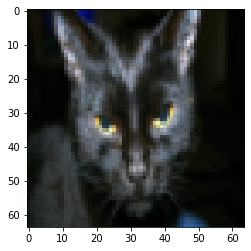

In [4]:
# Example of a picture
index = 25
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train[:, index]) + ", it's a '" + classes[np.squeeze(Y_train[:, index])].decode("utf-8") +  "' picture.")

## Prepping Data

In [5]:
X_train = X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test  = X_test_orig.reshape(X_test_orig.shape[0],-1).T

X_train = X_train / 255.
X_test = X_test / 255.

print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (12288, 209)
X_test shape: (12288, 50)


---
## Model Architecture
**Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Underlying Maths**:

For one sample $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

Cost function:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

## Helper Functions
---

### Sigmoid

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z (scalar or numpy array of any size.)
    Return: sigmoid(z)
    """
    return 1/(1+np.exp(-z))

### Initialize Parameters

In [7]:
def initialize_with_zeros(dim):
    """
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim,1))
    b = 0.    
    return w, b

### Forward + Backward Propagation
**Forward Propagation:**
* X -> A -> Cost Function, where
    * $A = \sigma(w^T X + b)$
    * Cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

**Backward Propagation:**

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [8]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation 
    Arguments:
    w -- weights, a numpy array (n_features,1)
    b -- bias, a scalar
    X -- data of size (n_features, m_samples)
    Y -- true "label" vector (1, m_samples)
    Returns:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION
    A = sigmoid(np.dot(w.T,X) + b)
    cost = (-1/m)*np.sum(np.log(A)*Y + np.log(1-A)*(1-Y))

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (+1/m)*np.dot(X,(A-Y).T)
    db = (+1/m)*np.sum(A-Y)

    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw, "db": db}
    
    return grads, cost

### Optimize

In [9]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias wrt the cost function
    costs -- list of all the costs computed during the optimization
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b) 
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w, "b": b}
    grads  = {"dw": dw, "db": db}
    
    return params, grads, costs

### Predict

In [10]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T,X) + b)
    
    for i in range(m):
        Y_prediction[0,i] = 1 if A[0,i] >= 0.5 else 0
        
    return Y_prediction

### Combining into an Overall Model

In [11]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    """
    # Initialize parameters as 0
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Optimize parameters over Training dataset
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations=num_iterations,
                                    learning_rate=learning_rate, print_cost=print_cost,)
    
    # Get final parameters
    w = params['w']
    b = params['b']
    
    # Make Predictions
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    # Print train/test fit
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

---
## Running Model

In [12]:
logistic_regression_model = model(X_train, Y_train, X_test, Y_test,
                                  num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


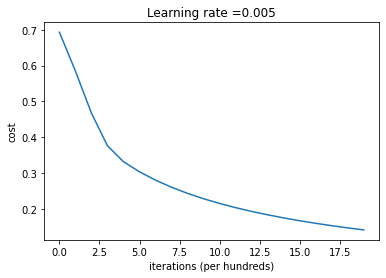

In [13]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

## Conclusion
The model clearly overfits with Train accuracy of ~100% but Test accuracy of only ~70%.  
However, the main takeaway here is buildign the **Logistic Regression model from first principles, without using Scikit-learn or any other library.**

### Some Results

y = 1, prediction is "non-cat" picture.


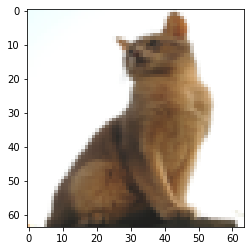

In [14]:
# Example of a wrong classification
index = 6
plt.imshow(X_test[:, index].reshape((64,64,3)))
print ("y = " + str(Y_test[0,index]) + ", prediction is \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

y = 1, prediction is "cat" picture.


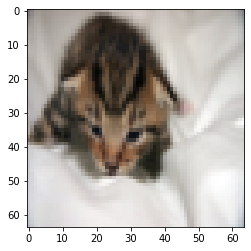

In [15]:
# Example of a correct classification
index = 1
plt.imshow(X_test[:, index].reshape((64,64,3)))
print ("y = " + str(Y_test[0,index]) + ", prediction is \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")